In [1]:
#https://www.kaggle.com/adityakadiwal/water-potability?select=water_potability.csv

In [1]:
# import generic libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#sns.set_theme()
plt.style.use('ggplot')
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# import classifier libraries
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer, recall_score, accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
#from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import StackingClassifier

import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

from tpot import TPOTClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer
from copy import copy

plt.rcParams['figure.figsize']=(18,10)
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

In [2]:
# load dataframe

water = pd.read_csv('water_potability.csv')

### Cleaning up the data

In [3]:
# review

water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
# create new column for drinkability description
water['drinkability'] = water['Potability'].map({0:'undrinkable',1:'drinkable'})

# convert column names to lower caps
water.columns = [i.lower() for i in water.columns]

# counts of water potability. 1 means potable aka drinkable.  0 means not potable
water.potability.value_counts()

0    1998
1    1278
Name: potability, dtype: int64

#### Visualizing imbalanced data

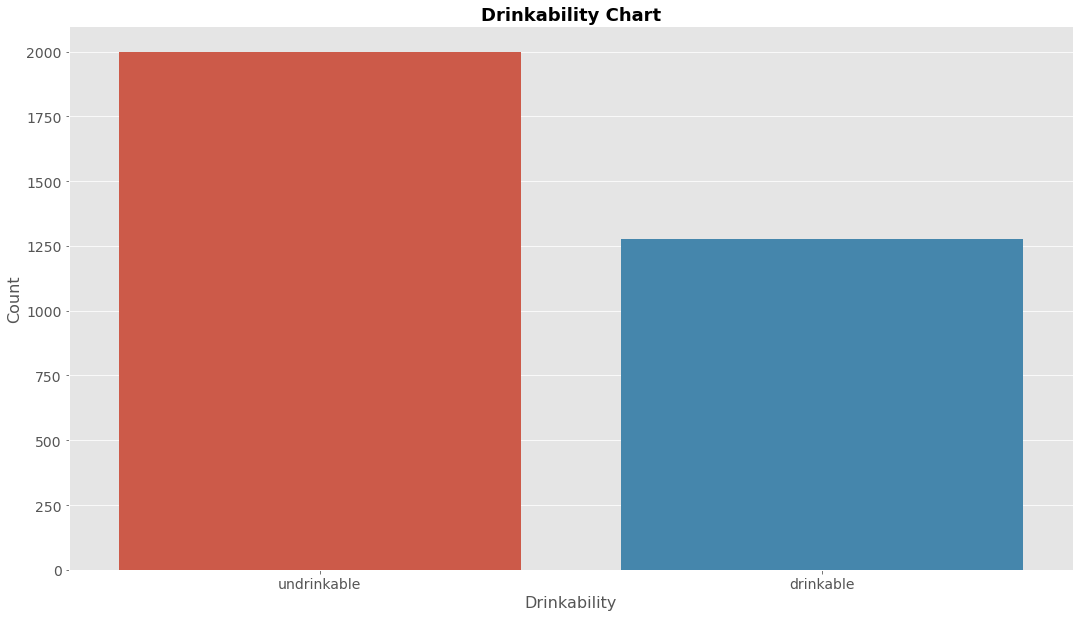

In [5]:
# compared drinkable with undrinkable. Imbalanced data

sns.countplot(data=water, x='drinkability')
plt.title('Drinkability Chart', fontsize=18, fontweight='bold')
plt.xlabel('Drinkability', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [6]:
# fill nan

water.fillna(method='ffill', inplace=True)
water.fillna(method='bfill', inplace=True)

# confirm no nan

water.isnull().sum()

ph                 0
hardness           0
solids             0
chloramines        0
sulfate            0
conductivity       0
organic_carbon     0
trihalomethanes    0
turbidity          0
potability         0
drinkability       0
dtype: int64

In [7]:
# define a function to standardize data and output to a dataframe

def normal(X):
    sc = StandardScaler()
    _ = sc.fit_transform(X)
    X = pd.DataFrame(data=_, columns=X.columns)
    return X



def confmat(y_test, y_pred):
    conf_mat=confusion_matrix(y_test, np.rint(y_pred))
    tp = conf_mat[1,1]
    tn = conf_mat[0,0]
    fp = conf_mat[0,1]
    fn = conf_mat[1,0]
    accuracy = round((tp+tn) / (float(tp+tn+fp+fn)),2)
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    return accuracy, specificity, sensitivity



# define function to build network architecture

def create_mlp(hidden_layer=10):
    mlp = keras.Sequential()
    for i in range(hidden_layer):
        mlp.add(keras.layers.Flatten())
        mlp.add(keras.layers.Dense(32, activation='relu'))
    mlp.add(keras.layers.Dense(1, activation='sigmoid'))
    learning_rate=0.001
    opt=Adam(learning_rate)
    mlp.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return mlp

# define function to include keras classifier into mlp object to work with sklearn
def keras_cl():
    mlp = KerasClassifier(build_fn= lambda: create_mlp(5), epochs=10)
    mlp._estimator_type = "classifier"
    return mlp



# create a function to output scores for different classifiers

def compute_score (model2, X, y):
    acc = []
    spec = []
    sens = []
    t=5
    kf = KFold(n_splits=t, random_state=4, shuffle=True)
    _ = normal(X) # standardize data and output to dataframe
    for train, test in kf.split(_): # rotating indexes
        X_train, X_test = _.iloc[train,:], _.iloc[test,:]
        y_train, y_test = y.iloc[train], y.iloc[test]
        model2.fit(X_train,y_train)
        y_pred = model2.predict(X_test)
        accuracy, specificity, sensitivity = confmat(y_test, y_pred)
        acc.append(accuracy) # accuracy score
        spec.append(specificity) # specificity
        sens.append(sensitivity) # sensitivity
    accuracy = np.mean(acc).round(decimals=2)
    specificity = np.mean(spec).round(decimals=2) 
    sensitivity = np.mean(sens).round(decimals=2)
    return accuracy, specificity, sensitivity



# define a function to summarize all the scores of classifiers

def summary_score(mymodels,model_names):
    acc = []
    for i, n in zip(mymodels, model_names):
        accuracy, specificity, sensitivity = compute_score(i,X,y) # call function
        cast = {'model':n,'accuracy': accuracy, 'specificity': specificity, 'sensitivity':sensitivity}
        acc.append(cast)
    summary = pd.DataFrame(data=acc, columns=['model','accuracy','specificity', 'sensitivity'])
    return summary



# create a function to output scores for stacking classifier

def stacking_score(estimators, X, y):
    accuracy, specificity, sensitivity = compute_score (estimators, X, y)
    # create dataframe for scalar data structure
    stack_df = pd.DataFrame({'model': 'StackingClassifier', 'accuracy': accuracy, 'specificity': specificity, \
                         'sensitivity': sensitivity}, index=[0])
    return stack_df



# create function to predict batches of water potability status

def predict_water(X, model3, threshold):
    X = normal(X)
    probability = model3.predict_proba(X)[:,1]
    predicted = probability > threshold
    sample['predict'] = predicted
    sample['predict'] = [0 if i == False else 1 for i in sample['predict'] ]
    drinkable = sample.predict.value_counts().loc[1]
    undrinkable = sample.predict.value_counts().loc[0]
    undrinkable_batches = sample.loc[sample['predict']==0, 'batch']
    drinkable_batches = sample.loc[sample['predict']==1, 'batch']
    print(f"There are {undrinkable} batches of water that are undrinkable, and {drinkable} which are drinkable.")
    print()
    print(f"Undrinkable:\n{undrinkable_batches}")
    print()
    print(f"Drinkable:\n{drinkable_batches}")
    
    
    
# plot the AUC curve for the models

total = []
def auc_score(mymodels,model_names):
    _=normal(X)
    X_train, X_test, y_train, y_test = train_test_split(_,y, test_size=0.3, random_state=2)
    h=1
    for model_1, name in zip(mymodels, model_names):
        y_preds = model_1.predict_proba(X_test)[:, 1]
        auc = round(roc_auc_score(y_test, y_preds),3)
        cast = {'model': name, 'auc score': auc}
        total.append(cast)
        fpr, tpr, thresholds  = roc_curve(y_test, y_preds)
        roc_auc = metrics.auc(fpr, tpr)
        plt.figure(figsize=(12,70))
        plt.subplot(9,1,h)
        lw = 2
        plt.plot(fpr, tpr, color='red', lw = lw, label = 'ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC Curve {name}")
        plt.legend(loc = "lower right")
        plt.show()
        h+=1
    
    classifier = pd.DataFrame(data=total, columns=['model','auc score'])
    order= classifier.sort_values('auc score', ascending=False).model
    classifier = classifier.sort_values('auc score', ascending=False)
    
    # plot 'classifier' barplot
    sns.barplot(data=classifier, x='auc score', y='model', order=order)
    plt.title('Measure Of Classifier Effectiveness', fontsize=20)
    plt.xlabel('AUC Score', fontsize= 18)
    plt.ylabel('Model Names', fontsize= 18)
    
    # return classifier dataframe
    return classifier



# create a function to adjust thresholds 

def compute_score_threshold (model1, X, y, threshold):
    _=normal(X)
    X_train, X_test, y_train, y_test = train_test_split(_,y, test_size=0.3, random_state=2)    
    
    # output probabilities
    probability = model1.predict_proba(X_test)[:,1]
        
    # setting threshold
    y_pred = probability > threshold
    
    acc, spec, sens = confmat(y_test, y_pred)
    accuracy = np.mean(acc).round(decimals=2)
    specificity = np.mean(spec).round(decimals=2) 
    sensitivity = np.mean(sens).round(decimals=2)

    return accuracy, specificity, sensitivity

### Fixing imbalanced data by upsampling 

In [88]:
# fixing imbalanced data
from sklearn.utils import resample

pot_0_value_counts = water['potability'].value_counts().loc[0]
pot_1_df = water[water['potability']==1]
pot_0_df = water[water['potability']==0]

# upsampling
pot_1_df_resampled = resample(pot_1_df, n_samples = pot_0_value_counts, replace=True )

# concatenate both dataframes together

water_resampled = pd.concat([pot_1_df_resampled,pot_0_df])
water_resampled = water_resampled.reset_index()

# review

water_resampled.potability.value_counts()

0    1998
1    1998
Name: potability, dtype: int64

### Feature Selection

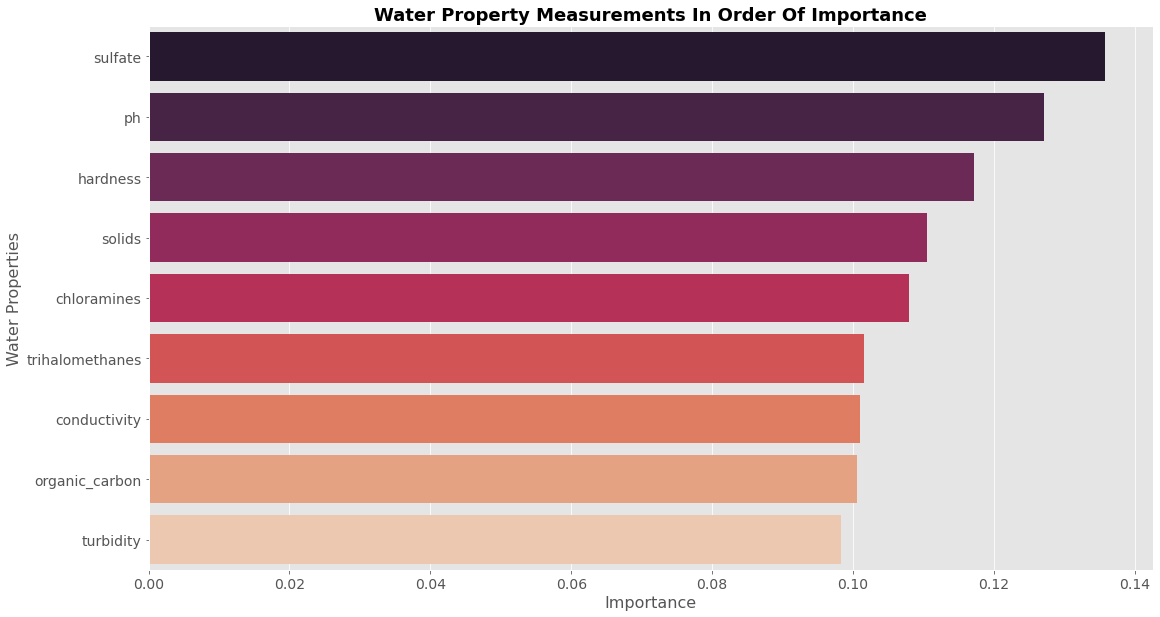

In [9]:
# defining predictors and labels

X = water_resampled.drop(['index','potability','drinkability'], axis=1)
y = water_resampled.potability

# import ExtraTreesClassifier and compute feature importance
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier()
clf.fit(X,y)
importance = clf.feature_importances_

# visualise feature importances

add = []
for col, imp in zip(X.columns, importance):
    cast = {'features': col, 'feature_importance': imp}
    add.append(cast)
feature_importance = pd.DataFrame(data=add, columns=['features','feature_importance'])

order = feature_importance.sort_values('feature_importance', ascending=False).features
sns.barplot(data=feature_importance, x='feature_importance', y='features', order=order, palette='rocket')
plt.title('Water Property Measurements In Order Of Importance', fontsize=18, fontweight='bold')
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Water Properties', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [58]:
order = feature_importance.sort_values('feature_importance', ascending=False)
order.to_excel('feature.xlsx')

#### Analyzing water properties between drinkable and undrinkable water

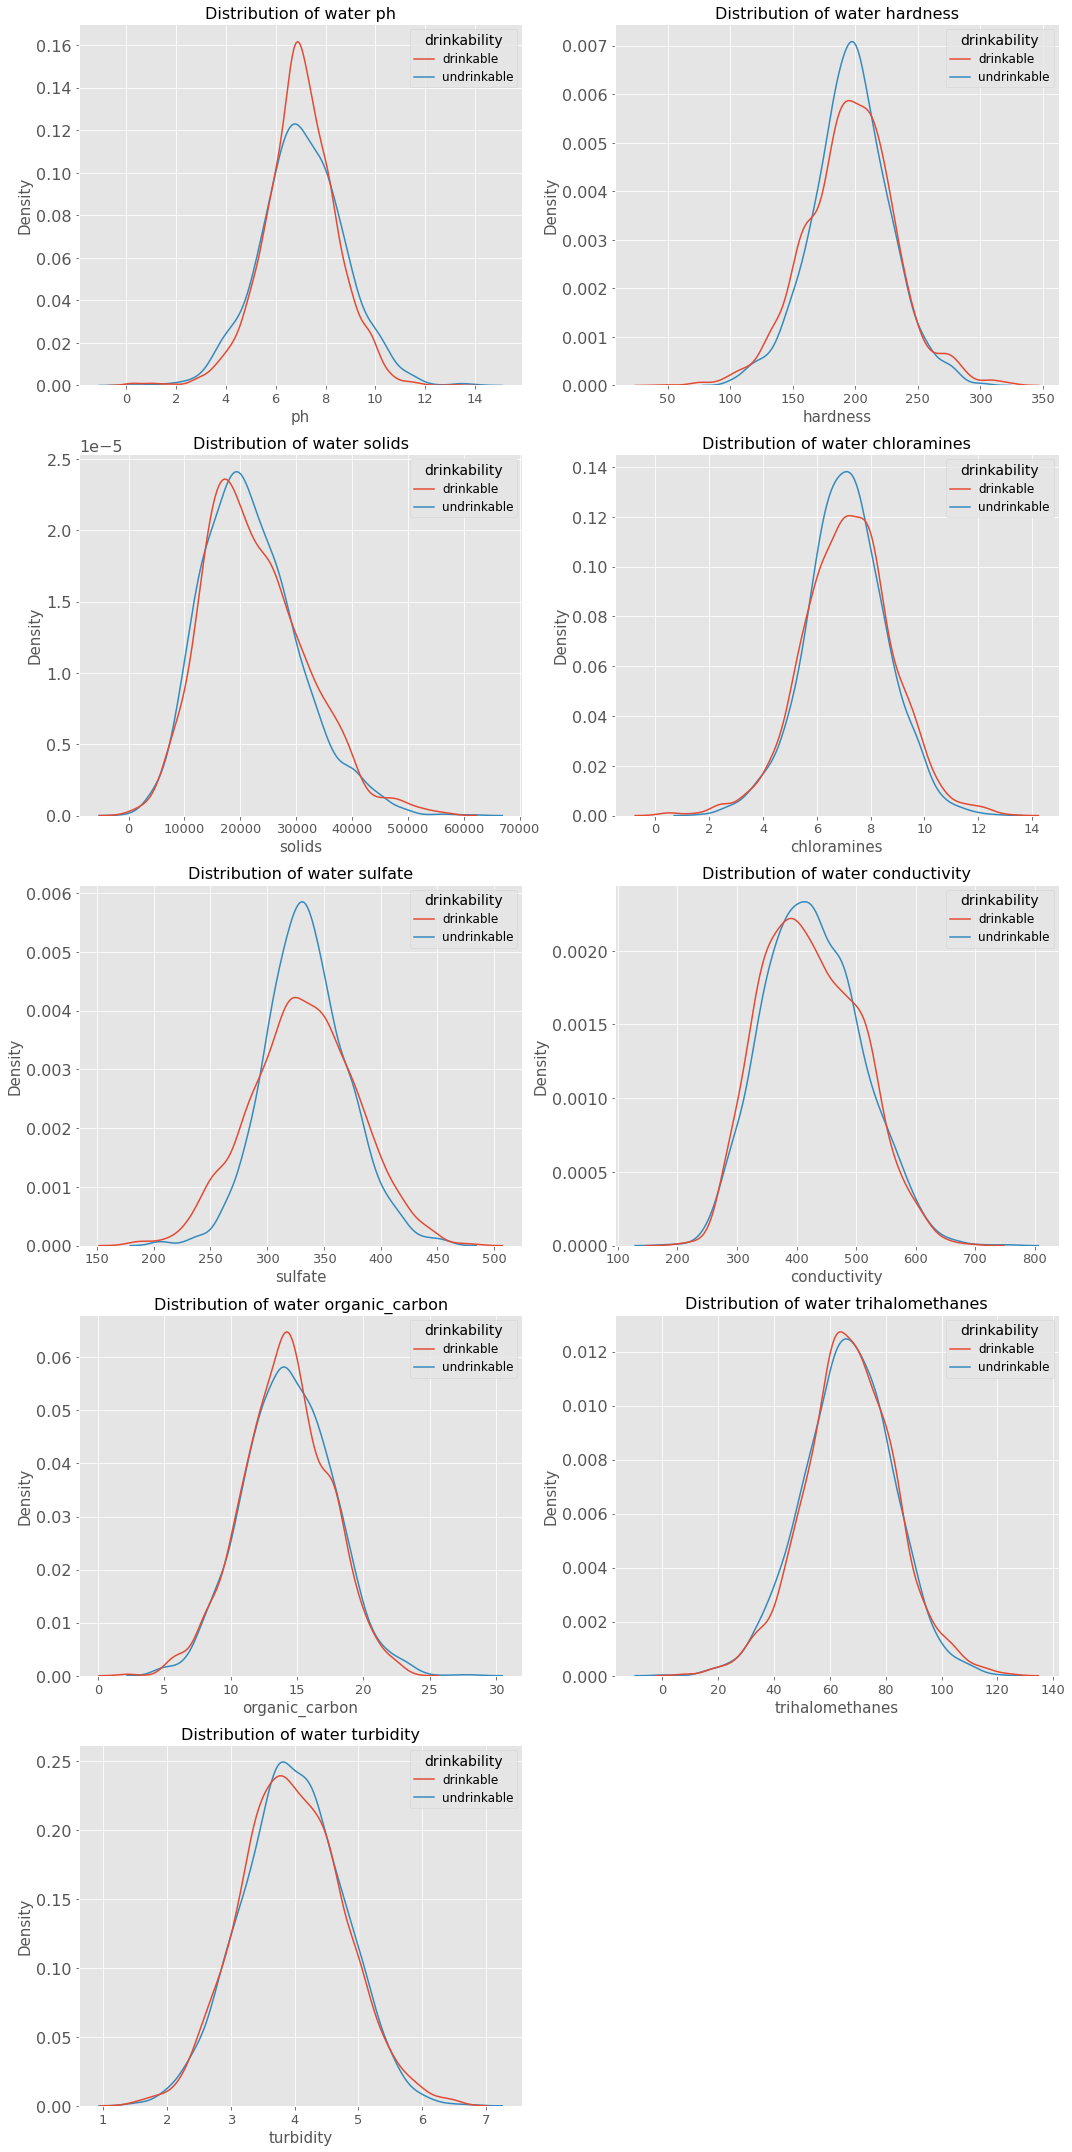

In [10]:
# plot graphs comparing distribution of various water propertise those which are potable and those which are not potable

fig=plt.gcf()
fig.set_size_inches(15,30)
h=1
for i in X.columns:
    plt.subplot(5,2,h)
    ax = sns.kdeplot(data=water_resampled, x=i, hue='drinkability');
    plt.setp(ax.get_legend().get_texts(), fontsize='12')
    plt.setp(ax.get_legend().get_title(), fontsize='14')
    plt.title(f"Distribution of water {i}", fontsize=16);
    plt.xticks(fontsize=13);
    plt.xlabel(f"{i}", fontsize=15);
    plt.ylabel('Density', fontsize=15);
    plt.tight_layout()
    h+=1

#### Feature selection by feature importances

#### Re-ordering columns according to feature importances

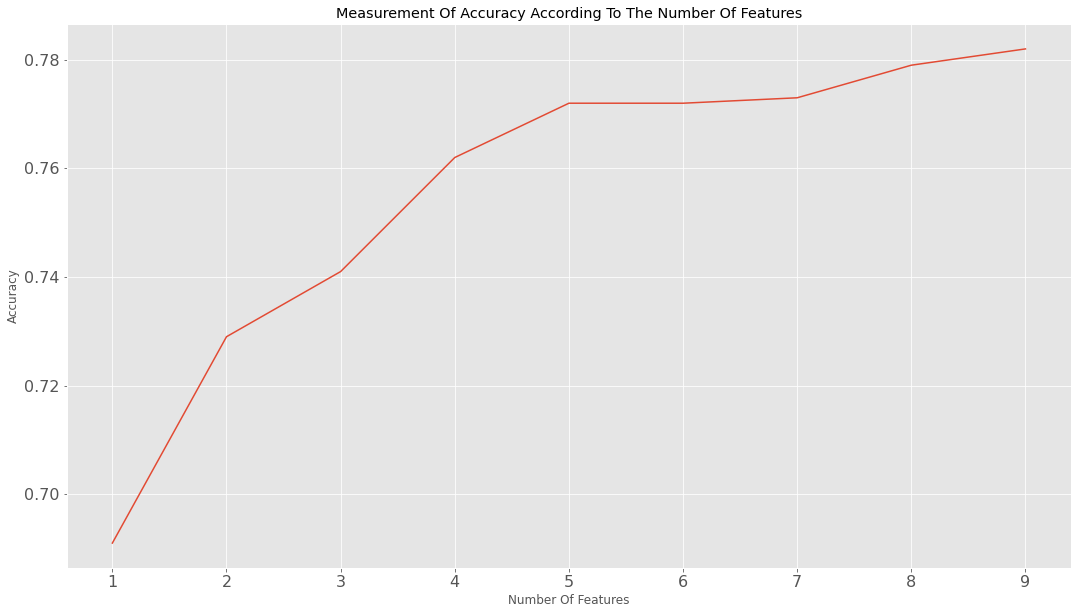

In [11]:
# reordering of columns according feature importance

temp = water_resampled[['index','sulfate','ph', 'hardness','chloramines', 'solids','conductivity',\
                       'trihalomethanes','organic_carbon','turbidity','potability']]
y = temp.potability

# standardize data
temp = normal(temp)

# Measuring accuracy score on adding features one by one starting from the most importance feature
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=13)

acc = []
for k in range(2,11):
    X = temp.iloc[:,1:k]
    mean_score = round(np.mean(cross_val_score(rfc, X, y,scoring='accuracy', cv=5)),3)
    cast = {'Number Of Features': k-1, 'Accuracy': mean_score }
    acc.append(cast)
    
accuracy_summary = pd.DataFrame(data=acc, columns=['Number Of Features','Accuracy'])
accuracy_summary

# visualize accuracy scores and number of features
sns.lineplot(data=accuracy_summary, x='Number Of Features', y='Accuracy')
plt.title('Measurement Of Accuracy According To The Number Of Features')

plt.show()

In [60]:
accuracy_summary.to_excel('feature_accuracy.xlsx')

#### Since by using all features will contribute to accuracy, we utilize all features

In [80]:
# assigning all features to X 

X = water_resampled[['sulfate','ph', 'hardness','chloramines', 'solids','conductivity',\
                       'organic_carbon','trihalomethanes','turbidity']]
y = water_resampled.potability

# review shape
X.shape, y.shape

((3996, 9), (3996,))

In [95]:
water_resampled.head()

,index,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability,drinkability
0,2842,6.080993,182.413992,31321.08243,7.624239,318.722751,498.454099,11.398007,81.288382,2.091787,1,drinkable
1,407,8.195765,214.517610,10389.54254,6.295405,327.193898,403.189913,15.067042,72.756812,3.218709,1,drinkable
2,660,7.543931,192.234541,24227.96114,7.241343,336.151050,369.427699,18.188873,70.588507,3.703191,1,drinkable
3,2446,9.166758,184.557434,21736.98180,12.227175,304.528521,317.583367,16.779566,51.052287,5.429266,1,drinkable
4,1516,9.241339,157.927492,31598.53638,6.778054,411.100692,464.025483,12.053627,93.871692,3.842578,1,drinkable


In [109]:
water_resampled_tb = water_resampled.drop(['index', 'potability'], axis=1)

In [110]:
water_resampled_tb = pd.melt(water_resampled_tb, id_vars = ['drinkability'], var_name=['properties'])

In [113]:
water_resampled_tb.tail(50)

,drinkability,properties,value
35914,undrinkable,turbidity,3.878664
35915,undrinkable,turbidity,3.439476
35916,undrinkable,turbidity,3.108674
35917,undrinkable,turbidity,3.860348
35918,undrinkable,turbidity,4.112598
35919,undrinkable,turbidity,2.545631
35920,undrinkable,turbidity,3.972256
35921,undrinkable,turbidity,3.946228
35922,undrinkable,turbidity,4.244514
35923,undrinkable,turbidity,4.295189


In [114]:
water_resampled_tb.to_excel('water_resampled_tb.xlsx')

## Hyper parameter tuning SVM

In [13]:
kernel = ['linear','rbf' ]
C = [ 20, 25]

result = {}

_ = normal(X) # standardize data and output to dataframe
temp=0

for kval in kernel:
    for cval in C:
        svm = SVC(kernel = kval, C=cval)
        acc = round(np.mean(cross_val_score(svm, _, y,scoring='accuracy', cv=5)),3)
        avg = np.mean(acc)
        if avg > temp:
            temp = avg
            kval_ = kval
            cval_ = cval

            result = {'kernel': kval_, 'C': cval_, 'accuracy': temp }
            
svm = SVC(kernel=kval_, C=cval_, probability=True)
result

{'kernel': 'rbf', 'C': 25, 'accuracy': 0.709}

## Hyper parameter tuning RandomForestClassifier

In [14]:
n_estimators = [150, 175, 200]
max_depth = range(10,15)
result = {}

_ = normal(X) # standardize data and output to dataframe
temp=0

for m in max_depth:
    for n in n_estimators:
        rfc = RandomForestClassifier(max_depth=m,n_estimators=n )
        acc = round(np.mean(cross_val_score(rfc, _, y,scoring='accuracy', cv=5)),3)
        avg = np.mean(acc)
        if avg > temp:
            temp = avg
            #print(f'TRANSITION -- n_estimators : {n}, max_depth : {m}, accuracy : {temp}')
            m_= m
            n_= n
            result = {'Depth': m_, 'Num_estimators': n_, 'accuracy': temp }
            

rfc = RandomForestClassifier(n_estimators=n_, max_depth=m_)
result

{'Depth': 14, 'Num_estimators': 175, 'accuracy': 0.801}

## Hyper parameter tuning KNearestNeighbors Classifier

In [15]:
n_neighbors = range(1,20)
weights = ['uniform','distance']
result = {}

_ = normal(X) # standardize data and output to dataframe
temp=0

for w in weights:
    for n in n_neighbors:
        knn = KNeighborsClassifier(n_neighbors=n, weights=w)
        acc = round(np.mean(cross_val_score(knn, _, y,scoring='accuracy', cv=5)),3)
        avg = np.mean(acc)
        if avg > temp:
            temp = avg
            w_ = w
            n_ = n
            #print(f'TRANSITION -- n_neighbors : {n}, weights : {w}, accuracy: {temp}')
            result = {'Weights': w_, 'N_neighbors': n_, 'accuracy': temp }
                    
# initialize model object
knn = KNeighborsClassifier(n_neighbors=n_, weights=w_)
result

{'Weights': 'uniform', 'N_neighbors': 1, 'accuracy': 0.766}

## Hyper parameter tuning DecisionTree Classifier

In [16]:
criterion = ['gini', 'entropy']
splitter = ['random','best']
max_depth = range(1,21)
result = {}
_ = normal(X) # standardize data and output to dataframe
temp = 0

for cval in criterion:
    for sval in splitter:
        for m in max_depth:
            dtc = DecisionTreeClassifier(criterion = cval, splitter=sval, max_depth = m)
            acc = round(np.mean(cross_val_score(dtc, _, y,scoring='accuracy', cv=5)),3)
            avg = np.mean(acc)
            if avg > temp:
                temp = avg
                cval_ = cval
                sval_ = sval
                m_ = m
                result = {'criterion': cval_, 'splitter': sval_, 'max_depth': m_, 'accuracy': temp }

# initialize model object
dtc = DecisionTreeClassifier(criterion =cval_, splitter=sval_, max_depth=m_)
result

{'criterion': 'gini', 'splitter': 'best', 'max_depth': 19, 'accuracy': 0.745}

## Hyper parameter tuning XGBoost

In [17]:
n_estimators = range(200, 400, 100)
subsample = [0.5,0.9]
colsample_bytree = [0.5,0.9]
max_depth = range(12,16)

result = {}
_ = normal(X) # standardize data and output to dataframe
temp=0

for sval in subsample:
    for cval in colsample_bytree:
        for m in max_depth:
            for n in n_estimators:
                xgb = XGBClassifier(n_estimators=n, subsample=sval, colsample_bytree=cval, max_depth = m)
                acc = round(np.mean(cross_val_score(xgb, _, y,scoring='accuracy', cv=5)),3)
                avg = np.mean(acc)
                if avg > temp:
                    temp = avg
                    sval_ = sval
                    cval_ = cval
                    m_ = m
                    n_ = n
                    result = {'subsample': sval_, 'colsample_bytree': cval_, 'max_depth': m_, 'n_estimators': \
                              n_,'accuracy': temp } 

# intialize classifier object                    
xgb = XGBClassifier(subsample=sval_, colsample_bytree=cval_, max_depth=m_, n_estimators=n_)
result

[20:17:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[20:17:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[20:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[20:17:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[20:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[20:18:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

{'subsample': 0.9,
 'colsample_bytree': 0.9,
 'max_depth': 14,
 'n_estimators': 300,
 'accuracy': 0.801}

In [15]:
# # initialize classifiers

xgb = XGBClassifier(subsample=0.9, colsample_bytree=0.9, max_depth=14, n_estimators=300)
dtc = DecisionTreeClassifier(criterion ='entropy', splitter='best', max_depth=19)
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform')
rfc = RandomForestClassifier(n_estimators=175, max_depth=14)
svm = SVC(kernel='rbf', C=25, probability=True)
gnb = GaussianNB()
mlp = keras_cl()

### Compute accuracy, specificity & sensitivity scores for all binary classifiers

In [16]:
# define a function to summarize all the scores of classifiers

mymodels = [xgb, dtc, knn, rfc, svm, gnb, mlp]
model_names = ['XGBoost','DecisionTree','KNearestNeighbors','RandomForest','SupportVectorMachine', 'GaussianNB',\
              'Multi-layerPerceptron_keras']

# call function "summary_score"

summary_df = summary_score(mymodels, model_names)
summary_df

[15:00:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,model,accuracy,specificity,sensitivity
0,XGBoost,0.81,0.78,0.83
1,DecisionTree,0.74,0.68,0.80
2,KNearestNeighbors,0.77,0.70,0.84
3,RandomForest,0.82,0.83,0.81
4,SupportVectorMachine,0.74,0.70,0.77
5,GaussianNB,0.58,0.68,0.47
6,Multi-layerPerceptron_keras,0.66,0.70,0.62


# StackingClassifier

#### Create a function to compute accuracy, specificity & sensitivity scores for StackingClassifier, using LogisticRegression as final estimater.

In [17]:
# create estimator list, final estimator is LogisticRegression
estimator_list = [('rfc', rfc),('svm',svm),('knn',knn),('dtc',dtc),('mlp',mlp), ('gnb',gnb),('xgb',xgb)] 

stc = StackingClassifier(estimators=estimator_list, final_estimator=LogisticRegression())

# calling function to output metrics scores for StackingClassifier based on estimator list
stack_df = stacking_score(stc, X, y)

Epoch 1/10
100/100 [==============================] - 0s 678us/step - loss: 0.6910 - accuracy: 0.5147
Epoch 2/10
100/100 [==============================] - 0s 711us/step - loss: 0.6725 - accuracy: 0.5848
Epoch 3/10
100/100 [==============================] - 0s 716us/step - loss: 0.6441 - accuracy: 0.6280
Epoch 4/10
100/100 [==============================] - 0s 712us/step - loss: 0.6149 - accuracy: 0.6589
Epoch 5/10
100/100 [==============================] - 0s 718us/step - loss: 0.5985 - accuracy: 0.6780
Epoch 6/10
100/100 [==============================] - 0s 715us/step - loss: 0.5757 - accuracy: 0.6984
Epoch 7/10
100/100 [==============================] - 0s 716us/step - loss: 0.5620 - accuracy: 0.7084
Epoch 8/10
100/100 [==============================] - 0s 722us/step - loss: 0.5485 - accuracy: 0.7206
Epoch 9/10
100/100 [==============================] - 0s 713us/step - loss: 0.5326 - accuracy: 0.7359
Epoch 10/10
100/100 [==============================] - 0s 718us/step - loss: 0.515

100/100 [==============================] - 0s 694us/step - loss: 0.6012 - accuracy: 0.6688
Epoch 5/10
100/100 [==============================] - 0s 703us/step - loss: 0.5884 - accuracy: 0.6919
Epoch 6/10
100/100 [==============================] - 0s 699us/step - loss: 0.5758 - accuracy: 0.7016
Epoch 7/10
100/100 [==============================] - 0s 699us/step - loss: 0.5697 - accuracy: 0.7075
Epoch 8/10
100/100 [==============================] - 0s 702us/step - loss: 0.5588 - accuracy: 0.7147
Epoch 9/10
100/100 [==============================] - 0s 707us/step - loss: 0.5470 - accuracy: 0.7204
Epoch 10/10
100/100 [==============================] - 0s 714us/step - loss: 0.5364 - accuracy: 0.7272
[15:01:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the 

100/100 [==============================] - 0s 735us/step - loss: 0.5381 - accuracy: 0.7269
[15:02:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Epoch 1/10
80/80 [==============================] - 0s 706us/step - loss: 0.6896 - accuracy: 0.5307
Epoch 2/10
80/80 [==============================] - 0s 744us/step - loss: 0.6670 - accuracy: 0.5933
Epoch 3/10
80/80 [==============================] - 0s 707us/step - loss: 0.6399 - accuracy: 0.6347
Epoch 4/10
80/80 [==============================] - 0s 694us/step - loss: 0.6124 - accuracy: 0.6625
Epoch 5/10
80/80 [==============================] - 0s 707us/step - loss: 0.5950 - accuracy: 0.6801
Epoch 6/10
80/80 [==============================] - 0s 644us/step - loss: 0.5802 - accuracy: 0.6903

Epoch 1/10
80/80 [==============================] - 0s 719us/step - loss: 0.6861 - accuracy: 0.5428
Epoch 2/10
80/80 [==============================] - 0s 683us/step - loss: 0.6663 - accuracy: 0.5968
Epoch 3/10
80/80 [==============================] - 0s 685us/step - loss: 0.6261 - accuracy: 0.6367
Epoch 4/10
80/80 [==============================] - 0s 691us/step - loss: 0.6043 - accuracy: 0.6668
Epoch 5/10
80/80 [==============================] - 0s 694us/step - loss: 0.5841 - accuracy: 0.6934
Epoch 6/10
80/80 [==============================] - 0s 683us/step - loss: 0.5711 - accuracy: 0.6989
Epoch 7/10
80/80 [==============================] - 0s 668us/step - loss: 0.5603 - accuracy: 0.7051
Epoch 8/10
80/80 [==============================] - 0s 697us/step - loss: 0.5459 - accuracy: 0.7231
Epoch 9/10
80/80 [==============================] - 0s 694us/step - loss: 0.5383 - accuracy: 0.7266
Epoch 10/10
80/80 [==============================] - 0s 679us/step - loss: 0.5205 - accuracy: 0.7493

In [18]:
summary_df2 = pd.concat([summary_df, stack_df])
summary_df2.reset_index(drop=True, inplace=True)
summary_df2.to_csv('summary_acc_spec_sens.csv')
summary_df2

,model,accuracy,specificity,sensitivity
0,XGBoost,0.81,0.78,0.83
1,DecisionTree,0.74,0.68,0.80
2,KNearestNeighbors,0.77,0.70,0.84
3,RandomForest,0.82,0.83,0.81
4,SupportVectorMachine,0.74,0.70,0.77
5,GaussianNB,0.58,0.68,0.47
6,Multi-layerPerceptron_keras,0.66,0.70,0.62
7,StackingClassifier,0.84,0.88,0.81


#### Visualize the scores of all binary classifiers & rank them as well

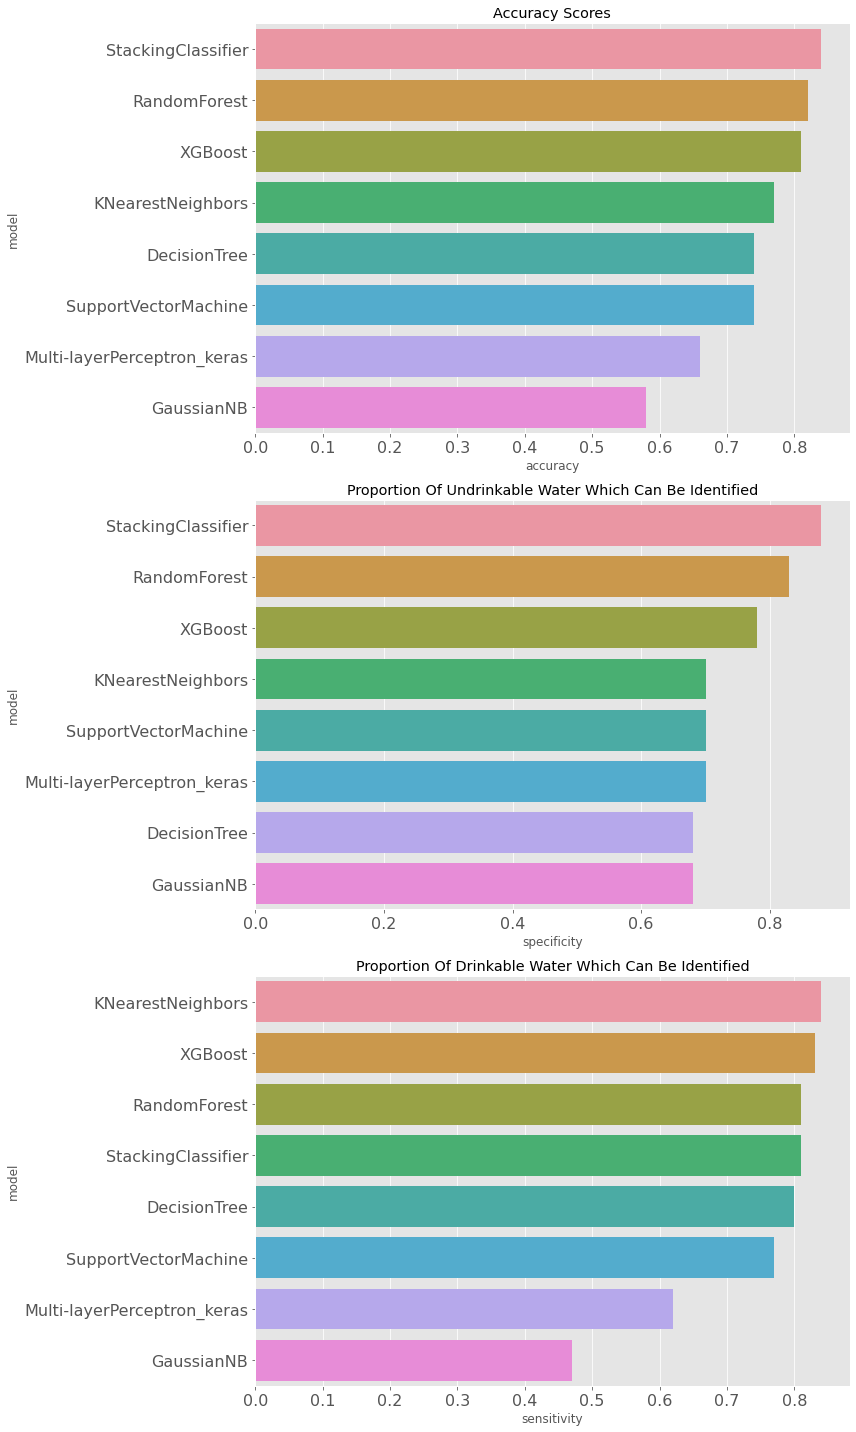

In [19]:
# visualize with graphs

scores = ['accuracy', 'specificity','sensitivity']
titles = ['Accuracy Scores', 'Proportion Of Undrinkable Water Which Can Be Identified',\
          'Proportion Of Drinkable Water Which Can Be Identified']

order1 = summary_df2.sort_values('accuracy', ascending=False).model
order2 = summary_df2.sort_values('specificity', ascending=False).model
order3 = summary_df2.sort_values('sensitivity', ascending=False).model
orders = [order1, order2, order3]

plt.figure(figsize=(12,20))
    
h=1
for score, title, order in zip(scores, titles, orders):
    plt.subplot(3,1,h)
    sns.barplot(data=summary_df2, x=score, y='model', order=order)
    plt.title(title)
    h+=1

plt.tight_layout()
plt.show()

### Visualizing with 2D plots using PCA & SVM

#### Standardize data & initialize pca object and output pca to new dataframe

In [20]:
# standardize the data using function 'normal'
_ = normal(X)

# initialize pca and transform to 2 pca components
pca = PCA(2)
X_pca = pca.fit_transform(_)

# assign to new dataframe
X_pca_df = pd.DataFrame(data=X_pca, columns=['pca_1','pca_2'])

In [21]:
X_pca_df.head()

,pca_1,pca_2
0,-1.879108,1.891439
1,-1.012276,-2.177359
2,-1.247135,0.857844
3,-0.093048,-0.213900
4,0.337756,-0.778944


In [22]:
# training support vector machine

svm1 = SVC(kernel='rbf')
svm1.fit(X_pca, y)

SVC()

### Visualization For SVM Classification with PCA

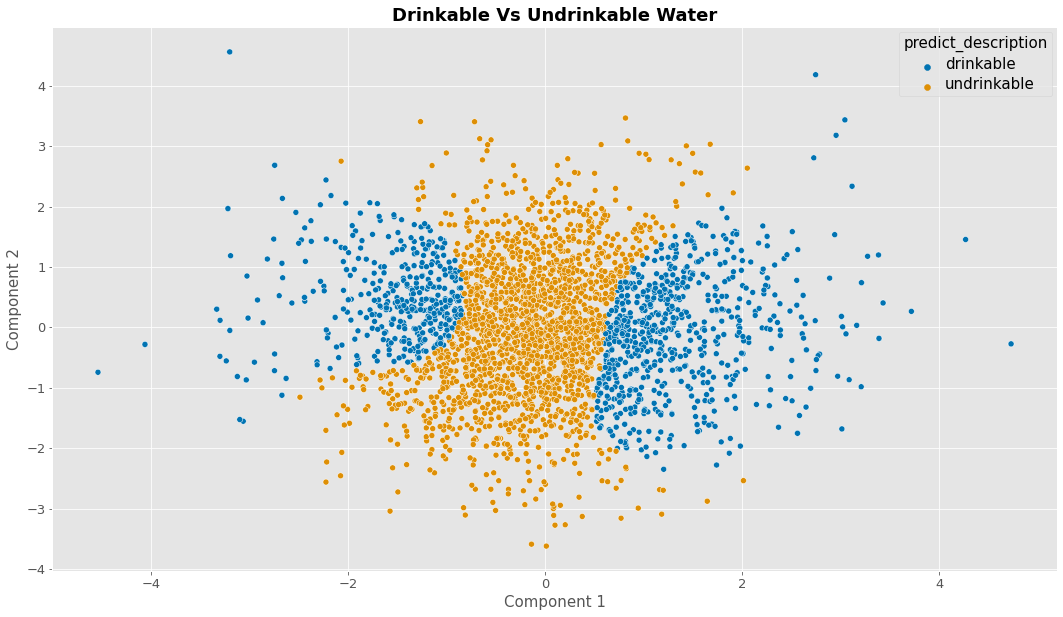

In [23]:
# prediction with SVM and visualize in scatterplot

y_pred = svm1.predict(X_pca) 
X_pca_df['prediction'] = y_pred

# create new column for prediction description
X_pca_df['predict_description'] = X_pca_df['prediction'].map(lambda x: 'undrinkable' if x==0 else 'drinkable')

# visualize using scatterplot
ax = sns.scatterplot(data=X_pca_df, x='pca_1', y='pca_2', hue='predict_description', palette='colorblind');
plt.setp(ax.get_legend().get_title(), fontsize=15);
plt.setp(ax.get_legend().get_texts(), fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Component 1', fontsize=15)
plt.ylabel('Component 2', fontsize=15)
plt.title('Drinkable Vs Undrinkable Water', fontsize=18, fontweight='bold')

plt.show()

In [48]:
X_pca_df.to_excel('X_pca.xlsx')

In [50]:
X_pca_df.head()

,pca_1,pca_2,prediction,predict_description
0,-1.879108,1.891439,1,drinkable
1,-1.012276,-2.177359,0,undrinkable
2,-1.247135,0.857844,1,drinkable
3,-0.093048,-0.213900,0,undrinkable
4,0.337756,-0.778944,0,undrinkable


### Can we visualize some prediction now with your raw data?  We will use PCA and  SVM visualize the prediction due to it's reasonable accuracy and specificity score.  But you can use another model if you like to.

In [24]:
# load raw client's data

sample = pd.read_csv('water_samples_3.csv')
sample.fillna(method='ffill', inplace=True)
# read sample

sample = sample[['batch','production_date','sulfate','ph', 'hardness','chloramines', 'solids','conductivity',\
                       'organic_carbon','trihalomethanes','turbidity']]

### Predict using SupportVectorMachine

In [25]:
# predict water potability based on features selected

_ = sample.loc[:,'sulfate':'turbidity']
s1 = normal(_)

# initialize PCA and transform to 2 components
pca = PCA(2)
pca_sample = pca.fit_transform(s1)

# create dataframe with PCA components
pca_sample_df = pd.DataFrame(data=pca_sample, columns=['pca_1','pca_2'])
pca_sample_df.index = pca_sample_df.index + 1

# predict with RFC and assign to new column
predicted = svm1.predict(pca_sample_df) # predict
pca_sample_df['prediction_svm'] = predicted

# compute a new column for label description
pca_sample_df['predict_description_svm'] = pca_sample_df['prediction_svm'].apply(lambda x: 'undrinkable'\
                                                                         if x == 0 else 'drinkable')


In [49]:
pca_sample_df.head()

,pca_1,pca_2,prediction_svm,predict_description_svm
batch,,,,
1,-1.433182,0.365389,1,drinkable
2,0.206634,0.456683,0,undrinkable
3,0.156884,-1.154409,0,undrinkable
4,-2.512538,1.083477,1,drinkable
5,0.527832,0.149951,0,undrinkable


### Output to Tableau

In [51]:
# predict water potability based on features selected

_ = sample.loc[:,'sulfate':'turbidity']
s1 = normal(_)

# initialize PCA and transform to 2 components
pca = PCA(2)
pca_sample_tb = pca.fit_transform(s1)

# create dataframe with PCA components
pca_sample_tb = pd.DataFrame(data=pca_sample_tb, columns=['pca_1','pca_2'])
#pca_sample_df.index = pca_sample_df.index + 1

# predict with RFC and assign to new column
predicted_tb = svm1.predict(pca_sample_tb) # predict
pca_sample_tb['prediction'] = predicted_tb

# compute a new column for label description
pca_sample_tb['predict_description'] = pca_sample_tb['prediction'].apply(lambda x: 'sample_undrinkable'\
                                                                         if x == 0 else 'sample_drinkable')

pca_sample_tb.head()

,pca_1,pca_2,prediction,predict_description
0,-1.433182,0.365389,1,sample_drinkable
1,0.206634,0.456683,0,sample_undrinkable
2,0.156884,-1.154409,0,sample_undrinkable
3,-2.512538,1.083477,1,sample_drinkable
4,0.527832,0.149951,0,sample_undrinkable


In [52]:
X_pca_tb = pd.concat([X_pca_df,pca_sample_tb], axis=0)

In [55]:
X_pca_tb.to_excel('X_pca_tb.xlsx')

#### Visualization For Classification Of Water

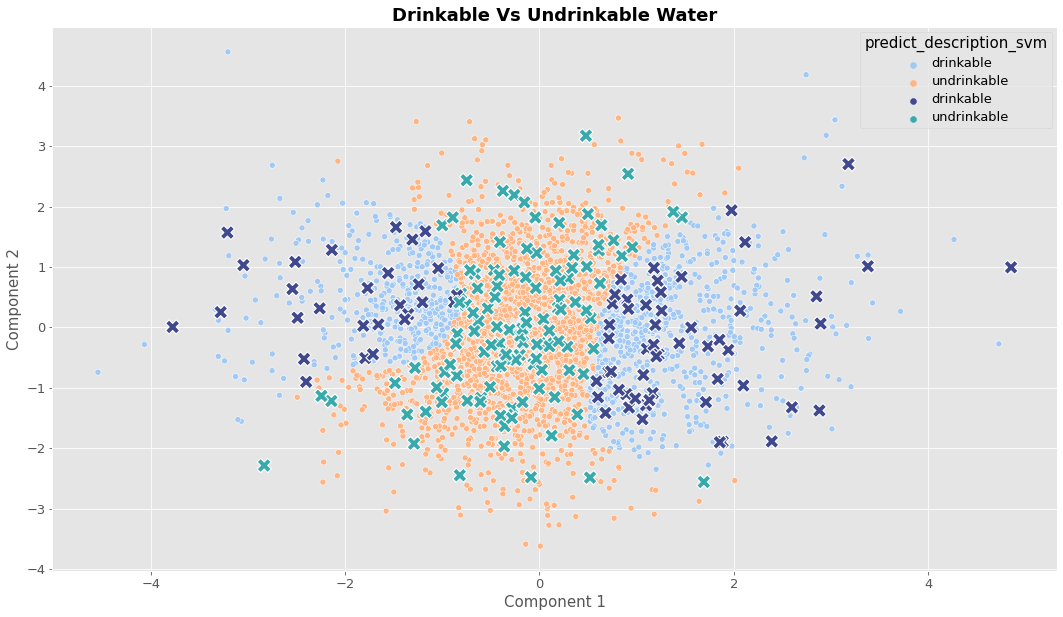

In [26]:
# visualize client's sample against predicted overall production records

sns.scatterplot(data=X_pca_df, x='pca_1', y='pca_2', hue='predict_description', palette='pastel');
ax =sns.scatterplot(data=pca_sample_df, x='pca_1', y='pca_2', hue='predict_description_svm', palette='mako', s=200, marker='X')
plt.setp(ax.get_legend().get_title(), fontsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Component 1', fontsize=15)
plt.ylabel('Component 2', fontsize=15)
plt.title('Drinkable Vs Undrinkable Water', fontsize=18, fontweight='bold')

plt.show()

In [27]:
# running batch numbers

pca_sample_df['batch'] = [i for i in range(1,pca_sample_df.shape[0]+1)]

In [28]:
# rearranging dataframe columns and re-indexing

pca_sample_df[['batch','pca_1','pca_2','prediction_svm','predict_description_svm']]
pca_sample_df.set_index('batch', inplace=True)
pca_sample_df.head()

,pca_1,pca_2,prediction_svm,predict_description_svm
batch,,,,
1,-1.433182,0.365389,1,drinkable
2,0.206634,0.456683,0,undrinkable
3,0.156884,-1.154409,0,undrinkable
4,-2.512538,1.083477,1,drinkable
5,0.527832,0.149951,0,undrinkable


In [29]:
# print out the status of the water

drinkable = pca_sample_df.prediction_svm.value_counts().loc[1]
undrinkable = pca_sample_df.prediction_svm.value_counts().loc[0]

print(f"SVM: There are {drinkable} batches of water that are drinkable, and {undrinkable} which are undrinkable.")

SVM: There are 81 batches of water that are drinkable, and 119 which are undrinkable.


In [30]:
X = sample.loc[:,'sulfate':'turbidity']
model3 = svm
threshold = 0.5

predict_water(X, model3, threshold)

There are 113 batches of water that are undrinkable, and 87 which are drinkable.

Undrinkable:
0        batch_1
1        batch_2
2        batch_3
3        batch_4
4        batch_5
         ...    
186    batch_187
190    batch_191
192    batch_193
194    batch_195
196    batch_197
Name: batch, Length: 113, dtype: object

Drinkable:
6        batch_7
7        batch_8
8        batch_9
9       batch_10
10      batch_11
         ...    
193    batch_194
195    batch_196
197    batch_198
198    batch_199
199    batch_200
Name: batch, Length: 87, dtype: object


# Optimized Pipeline

In [512]:
model = TPOTClassifier(generations=5, population_size=50, cv=cv, scoring='accuracy', verbosity=2,\
                       random_state=1, n_jobs=-1)

In [233]:
_ = normal(X)

model.fit(_, y)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8495171047142261

Generation 2 - Current best internal CV score: 0.852186274509804

Generation 3 - Current best internal CV score: 0.8535202336253651

Generation 4 - Current best internal CV score: 0.8535202336253651

Generation 5 - Current best internal CV score: 0.853770859407593

Best pipeline: RandomForestClassifier(CombineDFs(RFE(input_matrix, criterion=entropy, max_features=0.7000000000000001, n_estimators=100, step=0.1), input_matrix), bootstrap=False, criterion=entropy, max_features=0.15000000000000002, min_samples_leaf=2, min_samples_split=2, n_estimators=100)


TPOTClassifier(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
               generations=5, n_jobs=-1, population_size=50, random_state=1,
               scoring='accuracy', verbosity=2)

In [234]:
model.export('tpot_water_best_model.py')

In [33]:
# assigning all features to X 

X = water_resampled[['sulfate','ph', 'hardness','chloramines', 'solids','conductivity',\
                       'organic_carbon','trihalomethanes','turbidity']]
y = water_resampled.potability

In [34]:
pipe = make_pipeline(
    make_union(
        RFE(estimator=ExtraTreesClassifier(criterion="entropy", max_features=0.7000000000000001, n_estimators=100), step=0.1),
        FunctionTransformer(copy)
    ),
    RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.15000000000000002, min_samples_leaf=2, min_samples_split=2, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(pipe.steps, 'random_state', 1)


In [35]:
# compute metrics scores for Optimized Pipeline

mymodel= pipe

_ = normal(X)
accuracy, specificity, sensitivity = compute_score (mymodel, _, y)

In [36]:
print(f"TPOTClassifier\nAccuracy: {accuracy}\nSpecificity: {specificity}\nSensitivity: {sensitivity}")

TPOTClassifier
Accuracy: 0.85
Specificity: 0.88
Sensitivity: 0.82


## Classifier auc scores

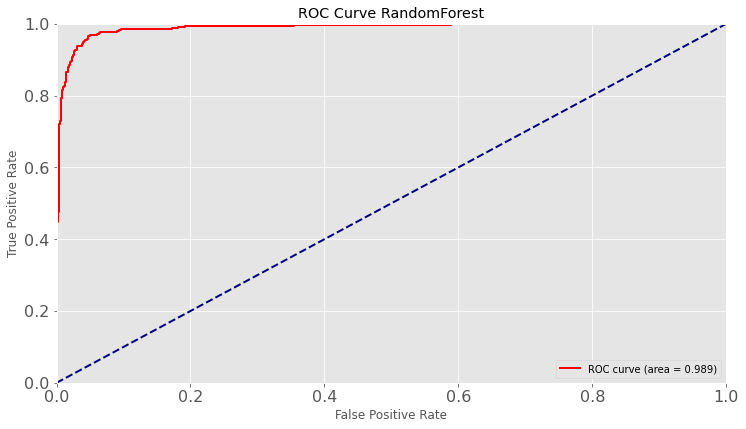

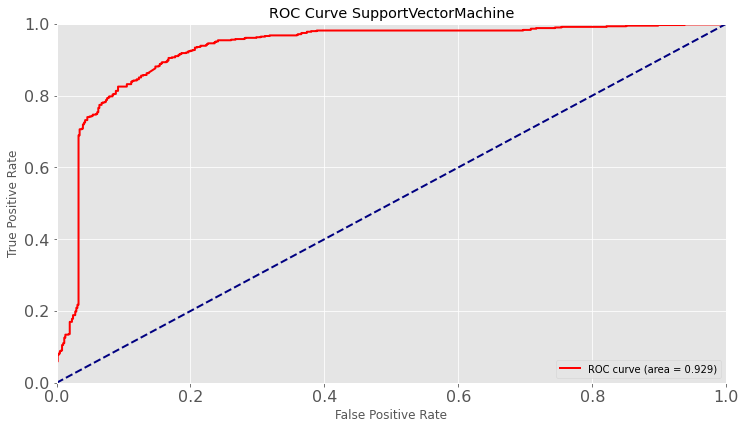

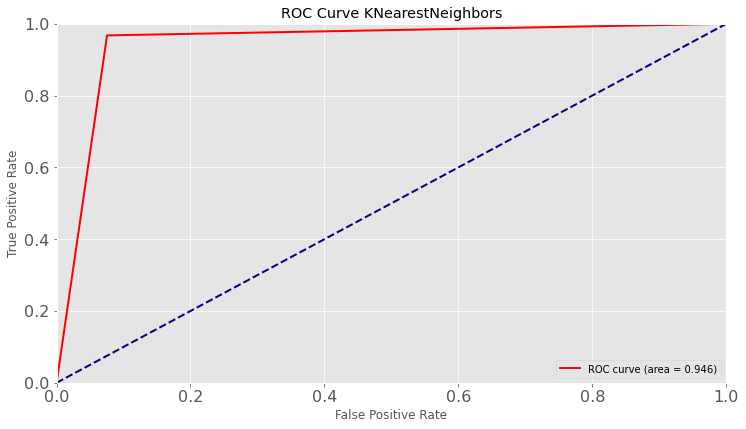

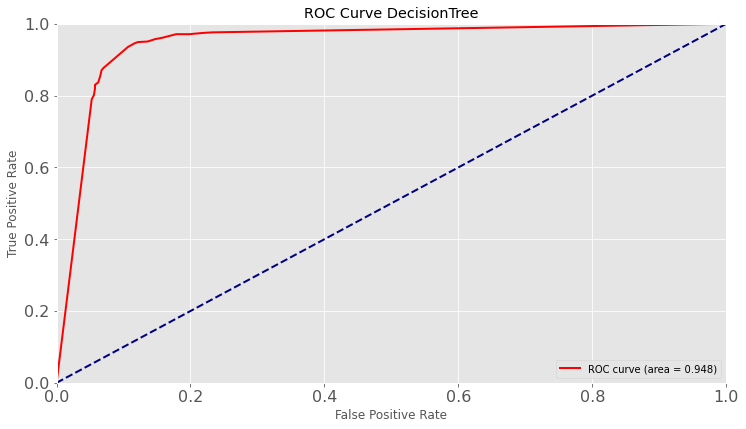

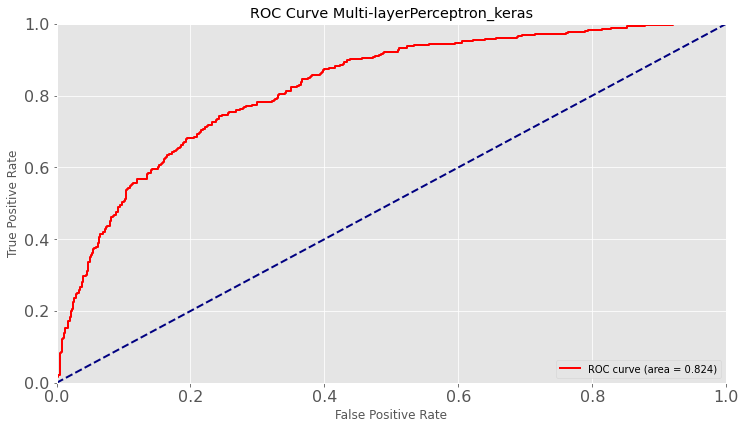

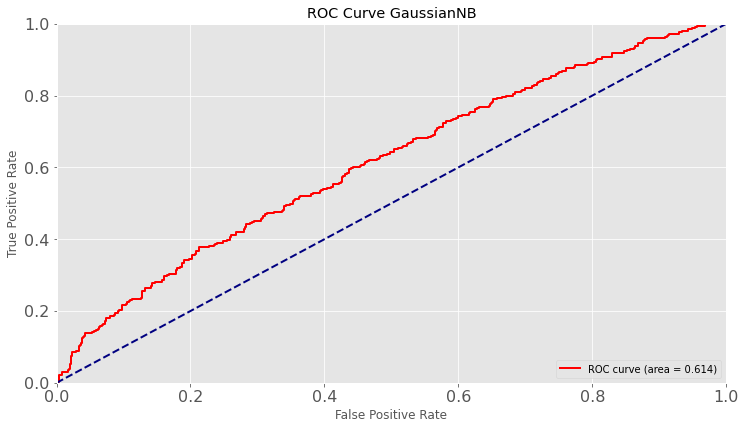

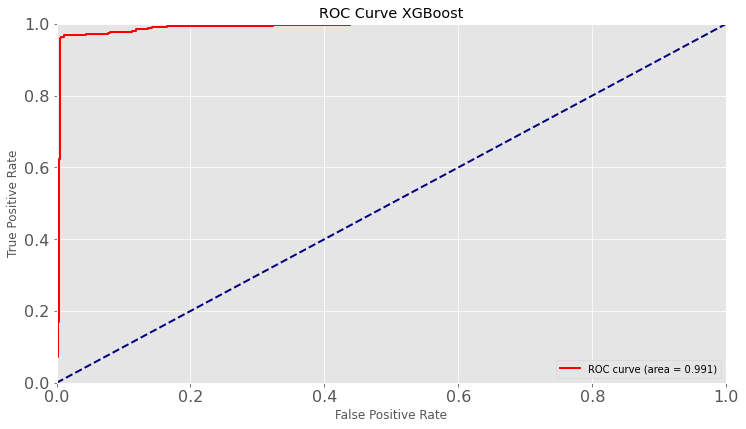

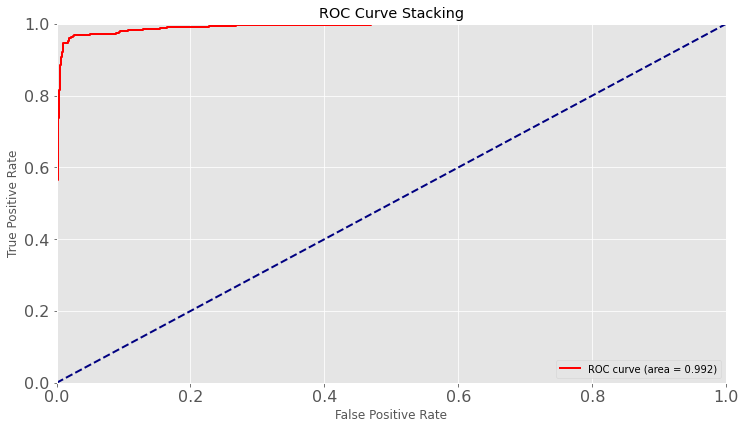

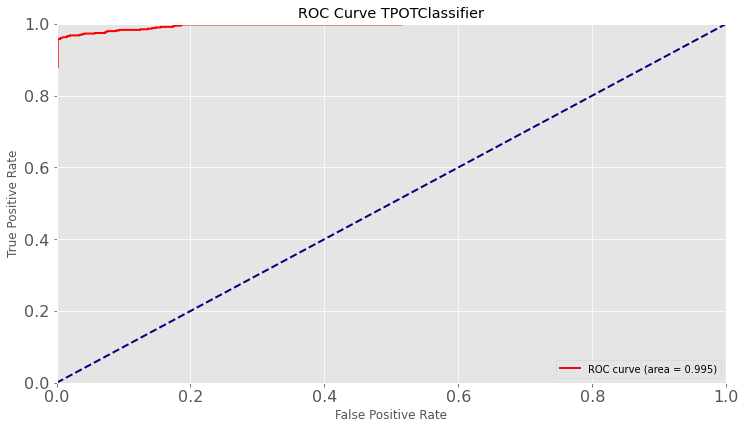

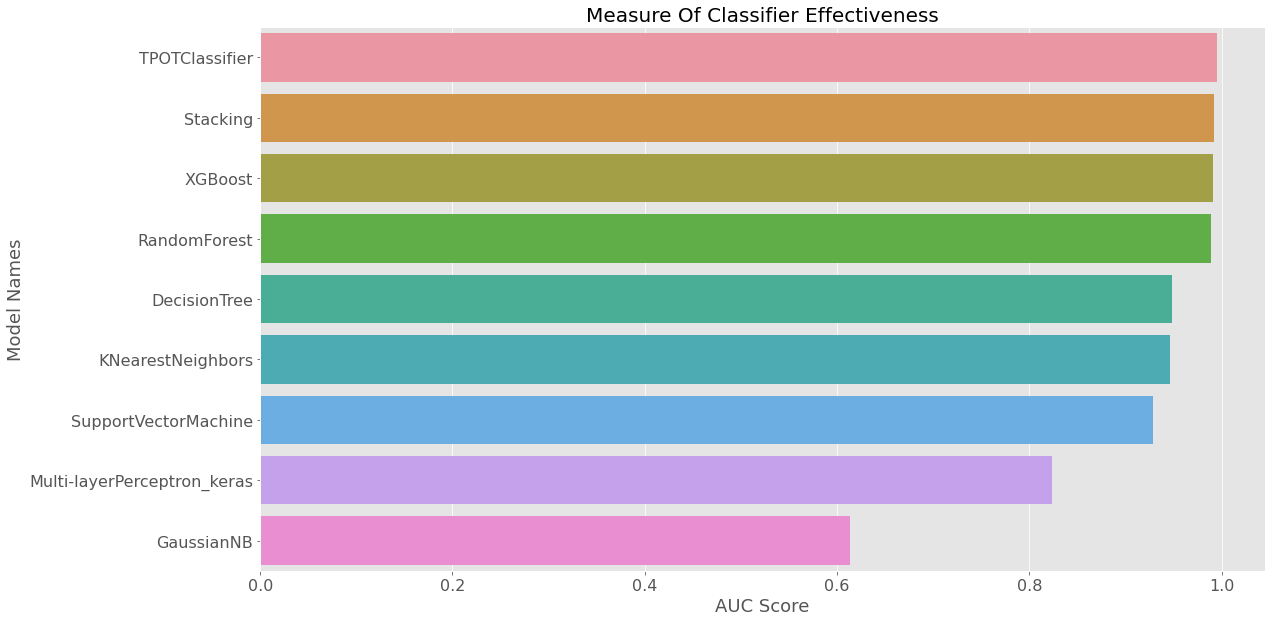

In [37]:
# mymodels = [pipe]
# model_names = ['TPOTClassifier']

# auc_score(mymodels, model_names)

mymodels = [rfc, svm, knn, dtc, mlp, gnb,xgb, stc,pipe]
model_names = ['RandomForest','SupportVectorMachine','KNearestNeighbors', 'DecisionTree', 'Multi-layerPerceptron_keras',\
              'GaussianNB','XGBoost','Stacking','TPOTClassifier']

water_classifier = auc_score(mymodels, model_names)

In [64]:
water_classifier.to_excel('water_classifier.xlsx')
water_classifier

,model,auc score
8,TPOTClassifier,0.995
7,Stacking,0.992
6,XGBoost,0.991
0,RandomForest,0.989
3,DecisionTree,0.948
2,KNearestNeighbors,0.946
1,SupportVectorMachine,0.929
4,Multi-layerPerceptron_keras,0.824
5,GaussianNB,0.614


# Use Optimized Pipeline for classification

## Since the cost of misclassification is high, we will adjust the threshold to accomodate misclassification. ie. increase Specificity, and reduce Sensitivity

In [39]:
X = water_resampled[['sulfate','ph', 'hardness','chloramines', 'solids','conductivity',\
                       'organic_carbon','trihalomethanes','turbidity']]
y = water_resampled.potability

In [61]:
threshold = np.arange(0.2, 0.9, 0.05)

total, total1 = list(), list()
mymodels = [pipe, stc, xgb]
model_names = ['TPOTClassifier', 'Stacking','XGBoost']

for m, mn in zip(mymodels, model_names):
    for k in threshold:
        accuracy, specificity, sensitivity = compute_score_threshold (m, X, y, k)
        cast = {'threshold': k, 'models': mn, 'scores': specificity, 'status': 'undrinkable'}
        total.append(cast)
        cast1 = {'threshold': k, 'models': mn, 'scores': sensitivity, 'status': 'drinkable'}
        total.append(cast1)
    
drinkability_df = pd.DataFrame(data=total, columns=['threshold','models','scores', 'status'])


In [63]:
drinkability_df.to_excel('drinkability_threshold.xlsx')

In [45]:
# # modifying legends

# drinkability_df['models_undrinkable'] = drinkability_df.models.map({'TPOTClassifier': 'TPOTClassifier_undrinkable',
#                                                     'Stacking': 'Stacking_undrinkable',
#                                                     'XGBoost':'XGBoost_undrinkable'})

# drinkability_df['models_drinkable'] = drinkability_df.models.map({'TPOTClassifier': 'TPOTClassifier_drinkable',
#                                                     'Stacking': 'Stacking_drinkable',
#                                                     'XGBoost':'XGBoost_drinkable'})

# drinkability_df = drinkability_df[['threshold','models_undrinkable','undrinkable','models_drinkable','drinkable']]

# drinkability_df.head()

In [46]:
# save dataframe to csv

drinkability_df.to_csv('drinkability_df2.csv', index=False)

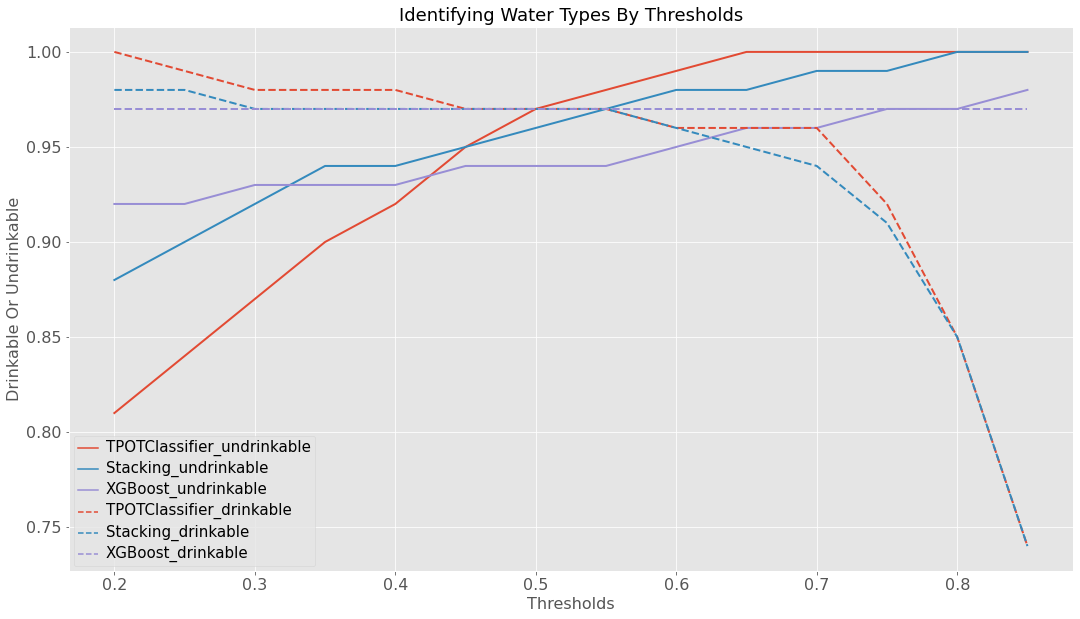

In [42]:
ax = sns.lineplot(data=drinkability_df, x='threshold', y='undrinkable', hue='models_undrinkable', linewidth=2)
ax = sns.lineplot(data=drinkability_df, x='threshold', y='drinkable', hue='models_drinkable', linestyle='--', linewidth=2)
plt.title('Identifying Water Types By Thresholds', fontsize= 18)
plt.xlabel('Thresholds', fontsize= 16)
plt.ylabel('Drinkable Or Undrinkable', fontsize= 16)


style = ax.legend()
style_lines = style.get_lines()
for i in range(3,6):
    style_lines[i].set_linestyle("--")

plt.setp(ax.get_legend().get_texts(), fontsize=15);

In [43]:
model1 = pipe
threshold = 0.4
accuracy, specificity, sensitivity = compute_score_threshold (model1, X, y, threshold)
print(f"TPOTClassifier Threshold of {threshold}\nAccuracy: {accuracy}\nSpecificity: {specificity}\nSensitivity: {sensitivity}")

TPOTClassifier Threshold of 0.4
Accuracy: 0.96
Specificity: 0.93
Sensitivity: 0.98


In [44]:
model1 = stc
threshold = 0.7
accuracy, specificity, sensitivity = compute_score_threshold (model1, X, y, threshold)
print(f"Stacking Threshold of {threshold}\nAccuracy: {accuracy}\nSpecificity: {specificity}\nSensitivity: {sensitivity}")

Stacking Threshold of 0.7
Accuracy: 0.96
Specificity: 0.99
Sensitivity: 0.93


In [45]:
model1 = xgb
threshold = 0.7
accuracy, specificity, sensitivity = compute_score_threshold (model1, X, y, threshold)
print(f"XGBoost Threshold of {threshold}\nAccuracy: {accuracy}\nSpecificity: {specificity}\nSensitivity: {sensitivity}")

XGBoost Threshold of 0.7
Accuracy: 0.97
Specificity: 0.96
Sensitivity: 0.97


In [46]:
model1 = rfc
threshold = 0.7
accuracy, specificity, sensitivity = compute_score_threshold(model1, X, y, threshold)
print(f"RandomForest Threshold of {threshold}\nAccuracy: {accuracy}\nSpecificity: {specificity}\nSensitivity: {sensitivity}")

RandomForest Threshold of 0.7
Accuracy: 0.86
Specificity: 1.0
Sensitivity: 0.72


In [47]:
_ = sample.loc[:,'sulfate':'turbidity']
model3 = pipe
threshold = 0.4

predict_water(_, model3, threshold)

There are 109 batches of water that are undrinkable, and 91 which are drinkable.

Undrinkable:
0        batch_1
1        batch_2
2        batch_3
3        batch_4
4        batch_5
         ...    
182    batch_183
183    batch_184
184    batch_185
189    batch_190
199    batch_200
Name: batch, Length: 109, dtype: object

Drinkable:
5        batch_6
6        batch_7
7        batch_8
8        batch_9
9       batch_10
         ...    
194    batch_195
195    batch_196
196    batch_197
197    batch_198
198    batch_199
Name: batch, Length: 91, dtype: object


In [50]:
_ = sample.loc[:,'sulfate':'turbidity']
model3 = stc
threshold = 0.6

predict_water(_, model3, threshold)

There are 134 batches of water that are undrinkable, and 66 which are drinkable.

Undrinkable:
0        batch_1
1        batch_2
2        batch_3
3        batch_4
4        batch_5
         ...    
187    batch_188
188    batch_189
189    batch_190
190    batch_191
199    batch_200
Name: batch, Length: 134, dtype: object

Drinkable:
5        batch_6
6        batch_7
7        batch_8
8        batch_9
9       batch_10
         ...    
194    batch_195
195    batch_196
196    batch_197
197    batch_198
198    batch_199
Name: batch, Length: 66, dtype: object


In [51]:
_ = sample.loc[:,'sulfate':'turbidity']
model3 = xgb
threshold = 0.6

predict_water(_, model3, threshold)

There are 117 batches of water that are undrinkable, and 83 which are drinkable.

Undrinkable:
0        batch_1
1        batch_2
2        batch_3
3        batch_4
4        batch_5
         ...    
183    batch_184
184    batch_185
187    batch_188
188    batch_189
189    batch_190
Name: batch, Length: 117, dtype: object

Drinkable:
5        batch_6
6        batch_7
7        batch_8
8        batch_9
9       batch_10
         ...    
195    batch_196
196    batch_197
197    batch_198
198    batch_199
199    batch_200
Name: batch, Length: 83, dtype: object
